# Examples for the AbsComponent Class (v2.1.1)

In [1]:
%matplotlib inline

# suppress warnings for these examples
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import
try:
    import seaborn as sns; sns.set_style("white")
except:
    pass
import numpy as np
from astropy.table import Table
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.isgm import utils as ltiu
from linetools.analysis import absline as laa
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
import linetools.analysis.voigt as lav
from linetools import utils as ltu

import imp
lt_path = imp.find_module('linetools')[1]

## Instantiate

### Standard

In [3]:
abscomp = AbsComponent((10.0*u.deg, 45*u.deg), (14,2), 1.0, [-300,300]*u.km/u.s)
abscomp

<AbsComponent: 00:40:00 +45:00:00, Name=SiII_z1.00000, Zion=(14,2), Ej=0 1 / cm, z=1, vlim=-300 km / s,300 km / s>

### From AbsLines

#### From one line

In [4]:
lya = AbsLine(1215.670*u.AA, z=2.92939)
lya.limits.set([-300.,300.]*u.km/u.s)  # vlim
# Column density
lya.attrib['flag_N'] = 1
lya.attrib['N'] = 1e17 /  u.cm**2
lya.attrib['sig_N'] = [1e16]*2 /  u.cm**2   # 2-sided errors (lower,upper) are now *required*

read_sets: Using set file -- 
  /home/xavier/local/Python/linetools/linetools/lists/sets/llist_v1.2.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [5]:
abscomp = AbsComponent.from_abslines([lya])
print(abscomp)
abscomp._abslines

<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>


[<AbsLine: HI 1215, z=2.9294 wrest=1215.6700 Angstrom, f=0.4164>]

#### From multiple

In [6]:
lyb = AbsLine(1025.7222*u.AA, z=lya.z)
lyb.limits.set([-300.,300.]*u.km/u.s)  # vlim

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [7]:
abscomp = AbsComponent.from_abslines([lya,lyb])
print(abscomp)
abscomp._abslines

<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>


[<AbsLine: HI 1215, z=2.9294 wrest=1215.6700 Angstrom, f=0.4164>,
 <AbsLine: HI 1025, z=2.9294 wrest=1025.7222 Angstrom, f=0.07914>]

## Dict I/O

In [8]:
cdict = abscomp.to_dict()
cdict

{'A': None,
 'DEC': 0.0,
 'Ej': 0.0,
 'Name': 'HI_z2.92939',
 'RA': 0.0,
 'Zion': (1, 1),
 'attrib': {'N': {'unit': '1 / cm2', 'value': 0.0},
  'b': {'unit': 'km / s', 'value': 0.0},
  'flag_N': 0,
  'logN': 0.0,
  'sig_N': {'unit': '1 / cm2', 'value': [0.0, 0.0]},
  'sig_b': {'unit': 'km / s', 'value': 0.0},
  'sig_logN': [0.0, 0.0],
  'sig_vel': {'unit': 'km / s', 'value': 0.0},
  'vel': {'unit': 'km / s', 'value': 0.0}},
 'class': 'AbsComponent',
 'comment': '',
 'lines': {1025.7222: {'analy': {'datafile': '',
    'do_analysis': 1,
    'flag_kin': 0,
    'flg_eye': 0,
    'flg_limit': 0,
    'name': 'HI 1025'},
   'attrib': {'DEC': 0.0,
    'EW': {'unit': 'Angstrom', 'value': 0.0},
    'N': {'unit': '1 / cm2', 'value': 0.0},
    'RA': 0.0,
    'b': {'unit': 'km / s', 'value': 0.0},
    'flag_EW': 0,
    'flag_N': 0,
    'logN': 0.0,
    'sig_EW': {'unit': 'Angstrom', 'value': 0.0},
    'sig_N': {'unit': '1 / cm2', 'value': 0.0},
    'sig_b': {'unit': 'km / s', 'value': 0.0},
    'si

### Write

In [9]:
abscomp.write('tmp.json')

Wrote AbsComponent to tmp.json


### Read

In [10]:
tcomp = AbsComponent.from_json('tmp.json')
tcomp

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>

## Define from Table and make a spectrum model

In [11]:

# We first create a Table with the most relevant information for defining AbsComponents
tab = Table()
tab['ion_name'] = ['HI', 'HI']
tab['Z'] = [1,1]
tab['ion'] = [1,1]
tab['Ej'] = [0.,0.] / u.cm
tab['z_comp'] = [0.2, 0.15]  
tab['logN'] = [19., 19.]  
tab['sig_logN'] = np.array([0.1, 0.1])  
tab['flag_logN'] = [1, 1] # Flags correspond to linetools notation
tab['RA'] = [0, 0]*u.deg  
tab['DEC'] = [0, 0]*u.deg 
tab['vmin'] = [-100, -100]*u.km/u.s  # This correspond to the velocity lower limit for the absorption components
tab['vmax'] = [100, 100]*u.km/u.s  # This correspond to the velocity upper limit for the absorption components
tab['b'] = [20, 20]*u.km/u.s  

# We now use this table to create a list of AbsComponents
complist = ltiu.complist_from_table(tab) 

# Now we need to add AbsLines to the component that are relevant for your spectrum
# This will be done by knowing the observed wavelength limits
wvlim = [1150, 1750]*u.AA
for comp in complist:
    comp.add_abslines_from_linelist(llist='HI') # you can also use llist="ISM" if you have other non HI components

# Finally, we can create a model spectrum for each AbsCompontent
wv_array = np.arange(1150,1750, 0.01) * u.AA  # This should match your spectrum wavelength array 
model_1 = lav.voigt_from_components(wv_array, [complist[0]])

read_sets: Using set file -- 
  /home/xavier/local/Python/linetools/linetools/lists/sets/llist_v1.2.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


## Methods

### Generate a Component Table of AbsLines

In [12]:
lya.attrib['logN'] = 14.1
lya.attrib['sig_logN'] = np.array([0.15]*2)
lya.attrib['flag_N'] = 1
laa.linear_clm(lya.attrib)
lyb.attrib['logN'] = 14.15
lyb.attrib['sig_logN'] = np.array([0.19]*2)
lyb.attrib['flag_N'] = 1
laa.linear_clm(lyb.attrib)

(<Quantity 141253754462275.53 1 / cm2>,
 <Quantity [  6.17972700e+13,  6.17972700e+13] 1 / cm2>)

In [13]:
abscomp = AbsComponent.from_abslines([lya,lyb])
comp_tbl = abscomp.build_table()
comp_tbl

name,wrest,z,flag_N,logN,sig_logN [2]
,Angstrom,,,,
str7,float64,float64,int64,float64,float64
HI 1215,1215.67,2.92939,1,14.1,0.15 .. 0.15
HI 1025,1025.7222,2.92939,1,14.15,0.19 .. 0.19


### Synthesize multiple components

In [14]:
SiIItrans = ['SiII 1260', 'SiII 1304', 'SiII 1526']
SiIIlines = []
for trans in SiIItrans:
    iline = AbsLine(trans, z=2.92939)
    iline.attrib['logN'] = 12.8 + np.random.rand()
    iline.attrib['sig_logN'] = np.array([0.15]*2)
    iline.attrib['flag_N'] = 1
    iline.limits.set([-300.,50.]*u.km/u.s)  # vlim
    _,_ = laa.linear_clm(iline.attrib)  # Fill in linear column density and error attributes
    SiIIlines.append(iline)
SiIIcomp = AbsComponent.from_abslines(SiIIlines)
SiIIcomp

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


<AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,50 km / s>

In [15]:
SiIIlines2 = []
for trans in SiIItrans:
    iline = AbsLine(trans, z=2.92939)
    iline.attrib['logN'] = 13.3 + np.random.rand()
    iline.attrib['sig_logN'] = 0.15
    iline.attrib['flag_N'] = 1
    iline.limits.set([50.,300.]*u.km/u.s)  # vlim
    _,_ = laa.linear_clm(iline.attrib)
    SiIIlines2.append(iline)
SiIIcomp2 = AbsComponent.from_abslines(SiIIlines2)
SiIIcomp2

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


<AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=50 km / s,300 km / s>

In [16]:
abscomp.synthesize_colm(overwrite=True)
[abscomp,SiIIcomp,SiIIcomp2]

[<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,50 km / s>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=50 km / s,300 km / s>]

In [17]:
synth_SiII = ltiu.synthesize_components([SiIIcomp,SiIIcomp2])
synth_SiII

<AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>

### Generate multiple components from abslines

In [18]:
comps = ltiu.build_components_from_abslines([lya,lyb,SiIIlines[0],SiIIlines[1]])
comps

[<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,50 km / s>]

### Generate an Ion Table -- Nearly Deprecated

In [19]:
tbl = ltiu.iontable_from_components([abscomp,SiIIcomp,SiIIcomp2])
tbl

Z,ion,A,Ej,z,vmin,vmax,flag_N,logN,sig_logN
,,,1 / cm,,km / s,km / s,,,
int64,int64,int64,float64,float64,float64,float64,int64,float64,object
1,1,0,0.0,2.92939,-300.0,300.0,0,0.0,[ 0. 0.]
14,2,0,0.0,2.92939,-300.0,300.0,0,0.0,[ 0. 0.]


### Generate an Ion Table

In [20]:
tbl2 = ltiu.table_from_complist([abscomp,SiIIcomp,SiIIcomp2])
tbl2

RA,DEC,comp_name,z_comp,Z,ion,Ej,vmin,vmax,ion_name,flag_N,logN,sig_logN [2],b,sig_b,vel,sig_vel,comment,reliability
deg,deg,,,,,1 / cm,km / s,km / s,,,,,km / s,km / s,km / s,km / s,,
float64,float64,str13,float64,int64,int64,float64,float64,float64,str4,int64,float64,float64,float64,float64,float64,float64,str1,str4
0.0,0.0,HI_z2.92939,2.92939,1,1,0.0,-300.0,300.0,HI,0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,,none
0.0,0.0,SiII_z2.92939,2.92939,14,2,0.0,-300.0,50.0,SiII,0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,,none
0.0,0.0,SiII_z2.92939,2.92939,14,2,0.0,50.0,300.0,SiII,0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,,none


### Stack plot

#### Load a spectrum

In [21]:
xspec = lsio.readspec(lt_path+'/spectra/tests/files/UM184_nF.fits')
lya.analy['spec'] = xspec
lyb.analy['spec'] = xspec

#### Show

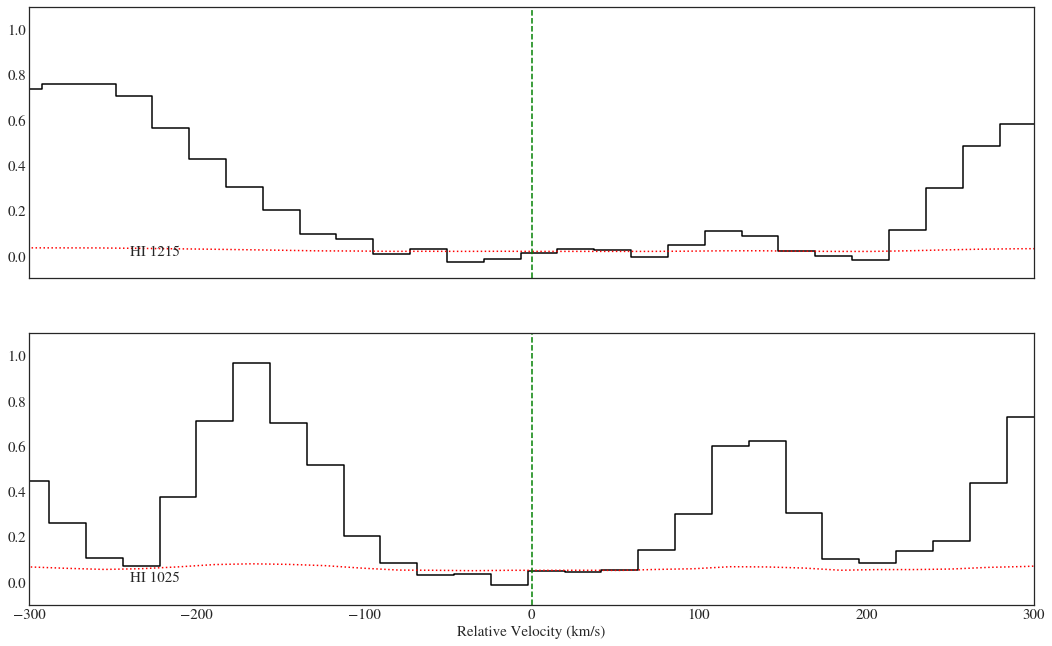

In [22]:
abscomp = AbsComponent.from_abslines([lya,lyb])
abscomp.stack_plot()